<a href="https://colab.research.google.com/github/ccg-esb/MI/blob/main/MI_6_PopulationModel_Evo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook evaluates the evolutionary dynamics of bacterial populations influenced by mobile integrons. It incorporates population-level simulations to explore how genetic variation, environmental pressures, and transitions between genotypes drive long-term adaptation. By modeling evolutionary processes such as mutation, recombination, and selection, the notebook simulates the role of mobile integrons in shaping fitness landscapes and evolutionary trajectories. These analyses provide a foundation for understanding the broader evolutionary implications of genetic mobility in microbial populations.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import itertools
import os
import pickle
from google.colab import drive
import random
import importlib
import sys
#import matplotlib.ticker as ticker
#from collections import defaultdict, deque, Counter
#import networkx as nx
#from concurrent.futures import ProcessPoolExecutor
#from collections import Counter

## Set experimental parameters

In [19]:
base_path = '/content/drive/MyDrive/SYNC_Projects/MI'

initial_resource = 1.0
simulation_time = 24.0
B0=1e6
num_days=30
dilution_factor=0.1

test_gene_labels=['GC1','GC2', 'X']

#test_gene_labels=['aacA37','aacA45', 'X'] #High polarity
test_gene_labels=['aacA37','smr1', 'X'] #Low polarity


cassettes = ['1', '2', 'X']
num_cassettes=len(cassettes)
initial_genotype_label = '12X'

max_antibiotic_concentration = 1.0
transition_rate=1e-5
p_sos_min = 0.1
c_sos = 0.5
k_sos = 10.0


In [20]:

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

#Data
sheet_url = 'https://docs.google.com/spreadsheets/d/1qJiSMeAn6yq9jhYNUi8X9zgw9gnzgbfuiCVTf6VTH2U/'

# Define the base path in Google Drive and a subdirectory for parameters
pathPARAMS = os.path.join(base_path, 'data/')
dirNameData = os.path.join(pathPARAMS, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")

pathFIGURES = os.path.join(base_path, 'figures/')
dirNameFigures = os.path.join(pathFIGURES, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")
os.makedirs(dirNameFigures, exist_ok=True)

if test_gene_labels[0] == 'GC1':  #Theoretical model
    k=0.1

    file_name_strains = f"{dirNameData}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_k{int(k*100)}e-2_strains.pkl"
    file_name_paths = f"{dirNameData}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_k{int(k*100)}e-2_paths.pkl"

    expe_label=f"X_{test_gene_labels[0]}_{test_gene_labels[1]}_k{int(k*100)}e-2"
    file_name_figures = f"{dirNameFigures}/{expe_label}"
else: #From data

    dirNameFigures = os.path.join(pathFIGURES, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")
    os.makedirs(dirNameFigures, exist_ok=True)

    file_name_strains = f"{dirNameData}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_strains.pkl"
    file_name_paths = f"{dirNameData}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_paths.pkl"

    expe_label=f"X_{test_gene_labels[0]}_{test_gene_labels[1]}"
    file_name_figures = f"{dirNameFigures}/{expe_label}"



pathCODE = os.path.join(base_path, 'code/')
sys.path.append(pathCODE)

import MI_GillespieModel
importlib.reload(MI_GillespieModel)
from MI_GillespieModel import *

print(file_name_strains)
print(file_name_figures)

Mounted at /content/drive
/content/drive/MyDrive/SYNC_Projects/MI/data/X_aacA37_smr1/X_aacA37_smr1_strains.pkl
/content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1


## Load Fitness Data

In [21]:


strains = load_strains_parameters(file_name_strains)
strains[0]['color']=[0,0,0]
print(strains)

Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_aacA37_smr1/X_aacA37_smr1_strains.pkl
[{'strainID': '000', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.9, 'half_saturation_antibiotic': 0.7, 'color': [0, 0, 0]}, {'strainID': '100', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.9, 'half_saturation_antibiotic': 0.7, 'color': array([0.83633987, 0.83633987, 0.83633987, 1.        ])}, {'strainID': '200', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.9, 'half_saturation_antibiotic': 0.7, 'color': array([0.77777778, 0.77777778, 0.77777778, 1.        ])}, {'strainID': 'X00', 'birth_rate': 0.8399999999999282, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.35999999999974164, 'half_saturation_antibiotic': 0.7, 'color': array([0.98535948, 0.45751634, 0.33202614, 1.        ])}, {'str

# Modeling excision/insertion of cassettes

In [22]:

M_exc, M_int, M_dup, list_genotypes = construct_transition_matrices(num_cassettes)
labels_genotypes = [format_genotype_label(g, num_cassettes) for g in list_genotypes]

weights = [0.4, 0.4, 0.2]  # 40% weight to M_exc, 40% to M_int, and 20% to M_dup
M = merge_matrices_with_diagonal_weighted(M_exc, M_int, M_dup, weights=[0.4, 0.4, 0.2])

print(list_genotypes)
print(labels_genotypes)

# Construct the tree
accessibility_tree_labels = construct_accessibility_tree_by_label(
    initial_genotype_label,
    labels_genotypes,
    M
)

# Print the resulting tree
accessible_strains=[]
for genotype, neighbors in accessibility_tree_labels.items():
    print(f"{genotype} -> {neighbors}")


keys_list = list(accessibility_tree_labels.keys())  # Get the list of keys from the dictionary

# Filter strains based on strainID being in keys_list
strains_accessible = [strain for strain in strains if strain['strainID'] in keys_list]
# Filter labels_genotypes to include only those in keys_list
labels_genotypes_accessible = [label for label in labels_genotypes if label in keys_list]

# Print the result
print(labels_genotypes_accessible)

# Crop transition matrices
M_exc_accessible, M_int_accessible = crop_transition_matrices(M_exc, M_int, labels_genotypes, labels_genotypes_accessible)
M_accessible = crop_transition_matrix(M, labels_genotypes, labels_genotypes_accessible)

['000', '100', '200', 'X00', '110', '120', '1X0', '210', '220', '2X0', 'X10', 'X20', 'XX0', '111', '112', '11X', '121', '122', '12X', '1X1', '1X2', '1XX', '211', '212', '21X', '221', '222', '22X', '2X1', '2X2', '2XX', 'X11', 'X12', 'X1X', 'X21', 'X22', 'X2X', 'XX1', 'XX2', 'XXX']
['000', '100', '200', 'X00', '110', '120', '1X0', '210', '220', '2X0', 'X10', 'X20', 'XX0', '111', '112', '11X', '121', '122', '12X', '1X1', '1X2', '1XX', '211', '212', '21X', '221', '222', '22X', '2X1', '2X2', '2XX', 'X11', 'X12', 'X1X', 'X21', 'X22', 'X2X', 'XX1', 'XX2', 'XXX']
12X -> ['120', '1X0', '2X0', '12X', '21X', 'X12']
120 -> ['100', '200', '120', '210', '112', '212']
1X0 -> ['100', 'X00', '1X0', 'X10', '11X', 'X1X']
2X0 -> ['200', 'X00', '2X0', 'X20', '22X', 'X2X']
21X -> ['1X0', '210', '2X0', '12X', '21X', 'X21']
X12 -> ['120', 'X10', 'X20', '1X2', '2X1', 'X12']
100 -> ['000', '100']
200 -> ['000', '200']
210 -> ['100', '200', '120', '210', '121', '221']
112 -> ['110', '120', '112', '211']
212 -> [

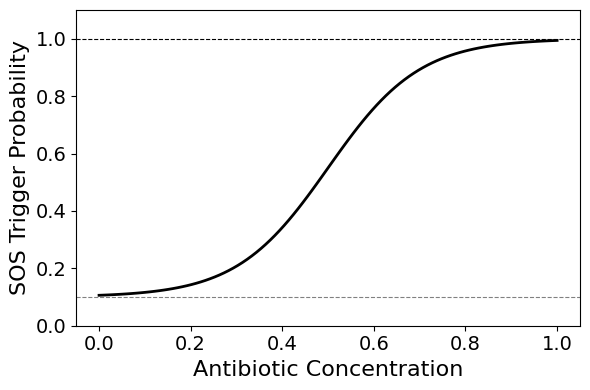

In [23]:
def plot_sos_probability(p_sos_min, c_sos, k_sos, max_antibiotic_concentration, resolution=100):
    """
    Plots the SOS probability as a function of antibiotic concentration.

    Parameters:
        p_sos_min (float): Minimum reshuffling probability (at zero antibiotic concentration).
        c_sos (float): Midpoint concentration of the sigmoid function.
        k_sos (float): Steepness of the sigmoid function.
        max_antibiotic_concentration (float): Maximum antibiotic concentration to consider.
        resolution (int): Number of points to evaluate the function for plotting.

    Returns:
        None: Displays the plot.
    """
    # Define antibiotic concentration range
    antibiotic_concentrations = np.linspace(0, max_antibiotic_concentration, resolution)

    # Compute SOS probabilities using the sigmoid function
    sos_probabilities = p_sos_min + (1 - p_sos_min) / (1 + np.exp(-k_sos * (antibiotic_concentrations - c_sos)))

    # Plot the SOS probabilities
    plt.figure(figsize=(6, 4))
    plt.plot(antibiotic_concentrations, sos_probabilities,  color='black', lw=2)
    plt.axhline(y=1, color='black', linestyle='--', linewidth=0.8)
    plt.axhline(y=p_sos_min, color='gray', linestyle='--', linewidth=0.8)
    #plt.axvline(x=c_sos, color='red', linestyle='--', linewidth=0.8)

    # Add labels and legend
    plt.xlabel('Antibiotic Concentration', fontsize=16)
    plt.ylabel('SOS Trigger Probability', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.ylim([0, 1.1])
    plt.show()

plot_sos_probability(
    p_sos_min=p_sos_min,   # Minimum reshuffling probability
    c_sos=c_sos,       # Midpoint concentration
    k_sos=k_sos,      # Steepness
    max_antibiotic_concentration=max_antibiotic_concentration # Maximum concentration
)


# Evolutionary experiments

In this analysis, we simulate the long-term evolutionary dynamics of bacterial populations in an environment without antibiotic pressure. All genotypes are initialized with equal population densities, and the simulation is carried out over multiple days using the combined transition matrix to account for excision, reintegration, and duplication dynamics.


### Evolutionary experiment (all strains, no drug)

Strain ID: 000, Initial Density: 1000000.0
Strain ID: 100, Initial Density: 1000000.0
Strain ID: 200, Initial Density: 1000000.0
Strain ID: X00, Initial Density: 1000000.0
Strain ID: 110, Initial Density: 1000000.0
 
Strain ID: 000, Final Density: 31022327.801137403
Strain ID: 100, Final Density: 26702774.249423407
Strain ID: 200, Final Density: 23175023.05154439
Strain ID: 110, Final Density: 19971259.150912322
Strain ID: 120, Final Density: 17730005.44384559
Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_all_A0_population_dynamics.pdf


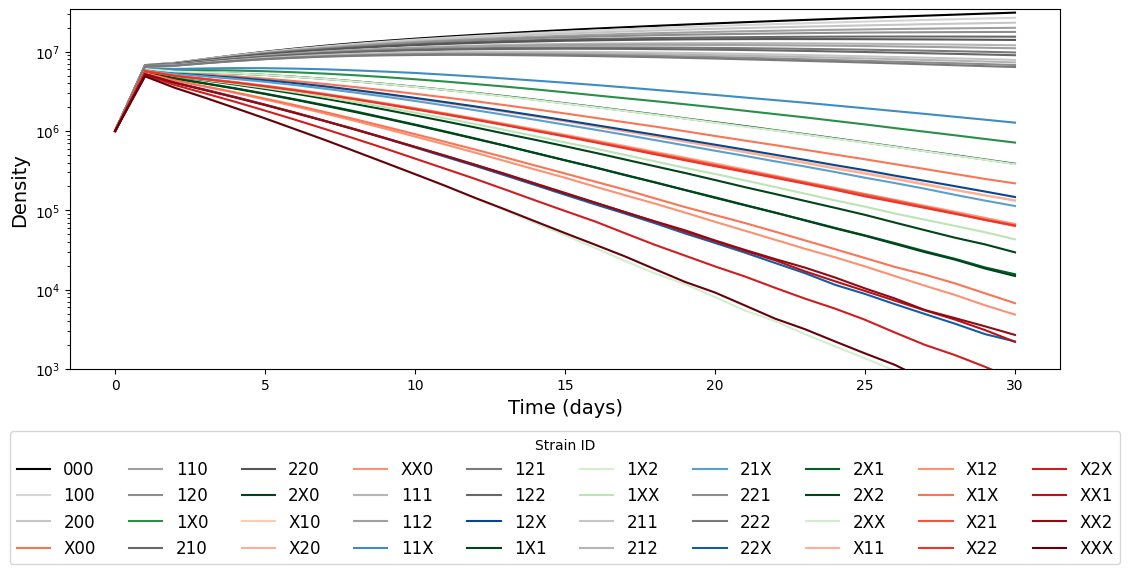

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_all_A0_final_density_bar.pdf


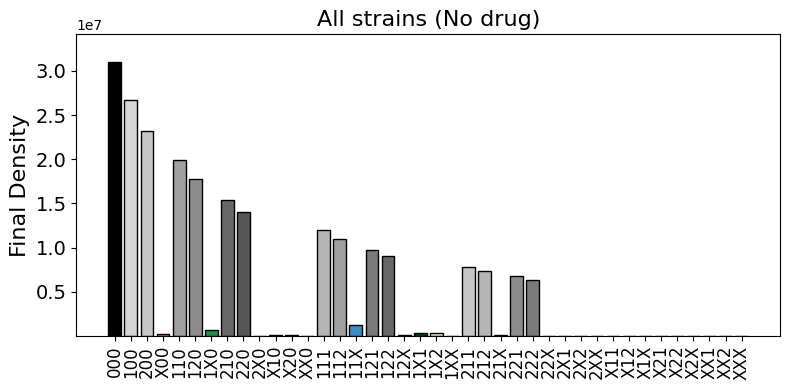

In [24]:

# Define initial populations for each strain
initial_populations = np.array([B0] * len(strains))

# Run the multi-day simulation
results_all_A0 = runSimulation(
    M=M,
    strains=strains,
    initial_populations=initial_populations,
    num_days=num_days,
    antibiotic_concentration=0.0, #no drug
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    dilution=dilution_factor,
    transition_rate=transition_rate,
    p_sos_min=p_sos_min,
    c_sos=c_sos,
    k_sos=k_sos,
    max_antibiotic_concentration=max_antibiotic_concentration
)


# Combine strain IDs with their final population densities
initial_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains, initial_populations)]
initial_sorted_strains = sorted(initial_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in initial_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Initial Density: {density}")
print(" ")

# Combine strain IDs with their final population densities
final_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains, results_all_A0[-1]['final_populations'])]
final_sorted_strains = sorted(final_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in final_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Final Density: {density}")


outPath='%s_all_A0'%(file_name_figures)
plotPopulationDynamics(results_all_A0, days=range(1, num_days + 1), strains=strains, initial_populations=initial_populations, ncol=10, outPath=outPath)

plotFinalDensityBar(results_all_A0, labels_genotypes, strains, title='All strains (No drug)', outPath=outPath)

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_total_population_total_population_dynamics.pdf


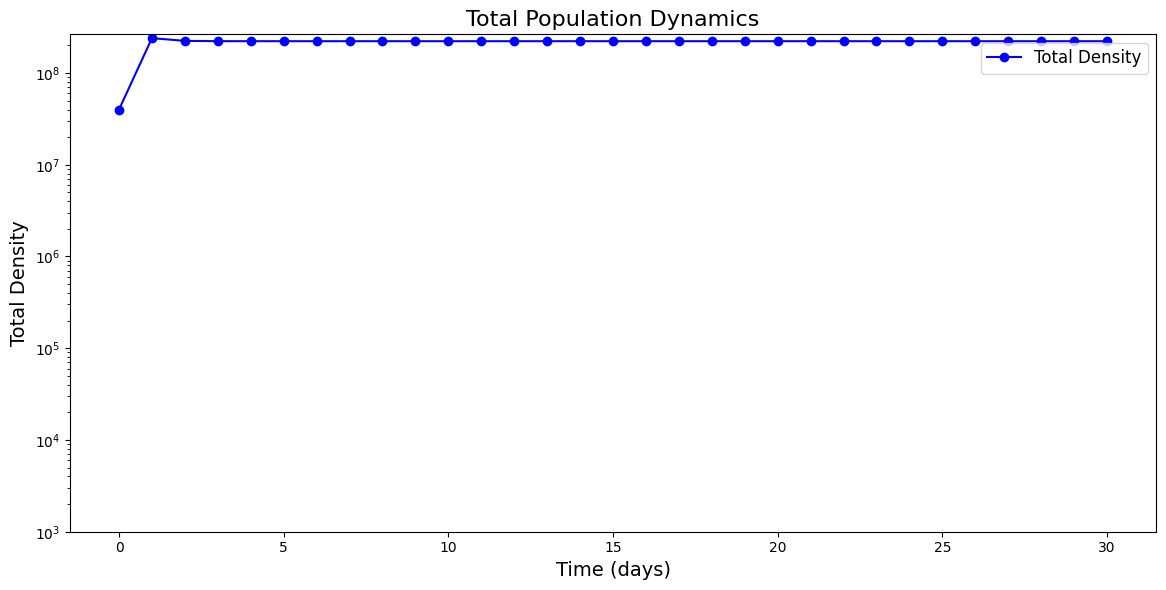

In [25]:
def plotTotalPopulationDynamics(results, days, initial_populations, outPath=''):
    """
    Plots the total population density over time.

    Parameters:
    results (list of dict): Simulation results with population densities.
    days (list of int): List of days to include in the plot.
    initial_populations (numpy array): Initial population densities for each strain at day 0.
    outPath (str): Path to save the plot (optional).
    """
    # Initialize lists to hold time and total population densities
    time_points = [0]  # Start with day 0
    total_densities = [np.sum(initial_populations)]  # Include initial total population at day 0

    # Extract data for each day in results
    for day_result in results:
        day = day_result['day']
        if day in days:
            # Append time point and total population density of the day
            time_points.append(day)
            total_density = np.sum(day_result['final_populations'])
            total_densities.append(total_density)

    # Plot the total population dynamics
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, total_densities, marker='o', linestyle='-', color='blue', label='Total Density')

    # Add labels and legend
    plt.xlabel('Time (days)', fontsize=14)
    plt.ylabel('Total Density', fontsize=14)
    plt.yscale('log')  # Log scale for density if values vary widely
    plt.title('Total Population Dynamics', fontsize=16)
    plt.legend(fontsize=12, loc='upper right')
    plt.tight_layout()
    plt.ylim([1e3, 1.1 * max(total_densities)])

    # Save or show plot
    if outPath:
        filename = f"{outPath}_total_population_dynamics.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()


outPath = '%s_total_population' % file_name_figures
plotTotalPopulationDynamics(results_all_A0, range(1, num_days + 1), initial_populations, outPath=outPath)


### Evolutionary experiment (all strains, with drug)

Strain ID: 000, Initial Density: 1000000.0
Strain ID: 100, Initial Density: 1000000.0
Strain ID: 200, Initial Density: 1000000.0
Strain ID: X00, Initial Density: 1000000.0
Strain ID: 110, Initial Density: 1000000.0
 
Strain ID: 2XX, Final Density: 29362095.03799677
Strain ID: XXX, Final Density: 4018675.4619335234
Strain ID: X2X, Final Density: 79426.61540798692
Strain ID: XX0, Final Density: 28951.410802279046
Strain ID: 2X0, Final Density: 16981.052009783263
Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_all_Amax_population_dynamics.pdf


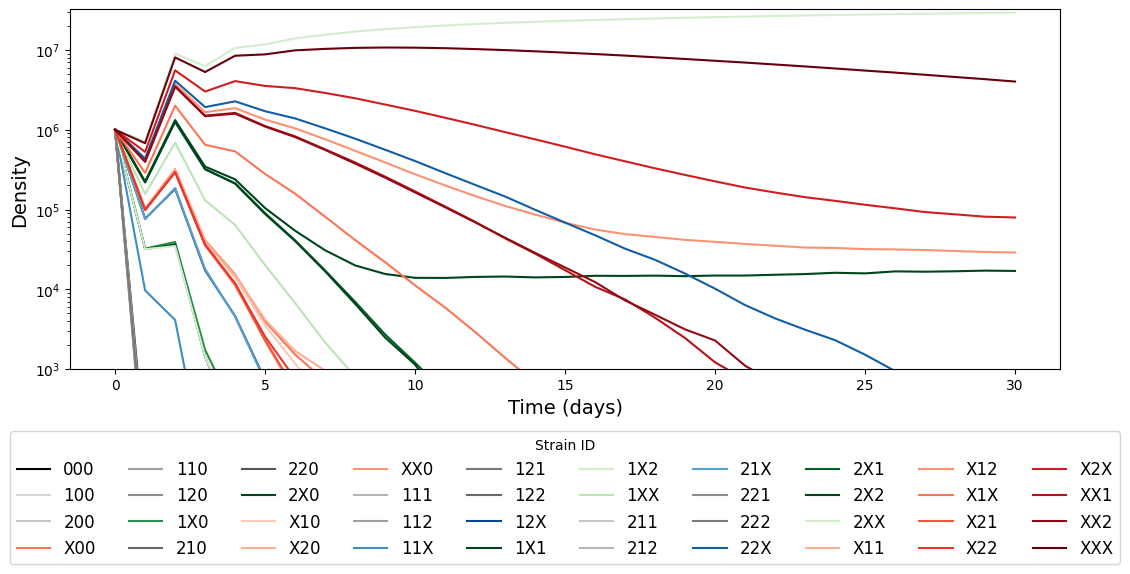

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_all_Amax_final_density_bar.pdf


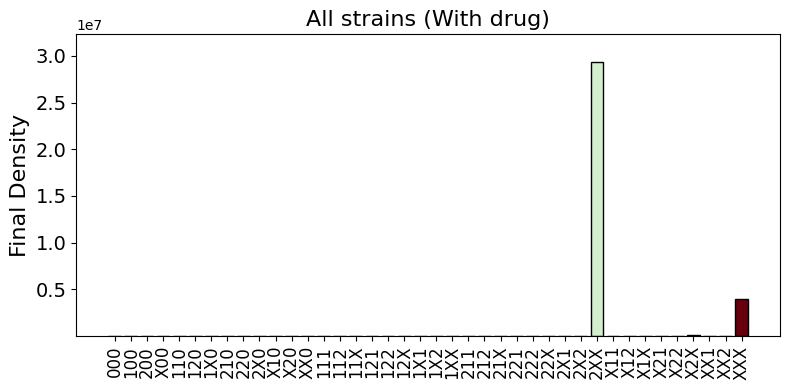

In [26]:


# Define initial populations for each strain
initial_populations = np.array([B0] * len(strains))

# Run the multi-day simulation
results_all_Amax = runSimulation(
    M=M,
    strains=strains,
    initial_populations=initial_populations,
    num_days=num_days,
    antibiotic_concentration=max_antibiotic_concentration,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    dilution=dilution_factor,
    transition_rate=transition_rate,
    p_sos_min=p_sos_min,
    c_sos=c_sos,
    k_sos=k_sos,
    max_antibiotic_concentration=max_antibiotic_concentration
)



# Combine strain IDs with their final population densities
initial_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains, initial_populations)]
initial_sorted_strains = sorted(initial_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in initial_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Initial Density: {density}")
print(" ")

# Combine strain IDs with their final population densities
final_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains, results_all_Amax[-1]['final_populations'])]
final_sorted_strains = sorted(final_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in final_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Final Density: {density}")


outPath='%s_all_Amax'%(file_name_figures)
plotPopulationDynamics(results_all_Amax, days=range(1, num_days + 1), strains=strains, initial_populations=initial_populations, ncol=10, outPath=outPath)


plotFinalDensityBar(results_all_Amax, labels_genotypes, strains, title='All strains (With drug)', outPath=outPath)

### Evolutionary experiment (accessible genotypes, no drug)

Strain ID: 000, Initial Density: 1000000.0
Strain ID: 100, Initial Density: 1000000.0
Strain ID: 200, Initial Density: 1000000.0
Strain ID: X00, Initial Density: 1000000.0
Strain ID: 110, Initial Density: 1000000.0
 
Strain ID: 000, Final Density: 30825776.00327573
Strain ID: 100, Final Density: 26613065.84516035
Strain ID: 200, Final Density: 23180005.47963193
Strain ID: 110, Final Density: 20062363.325016577
Strain ID: 120, Final Density: 17781719.47869358
Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_accessible_A0_population_dynamics.pdf


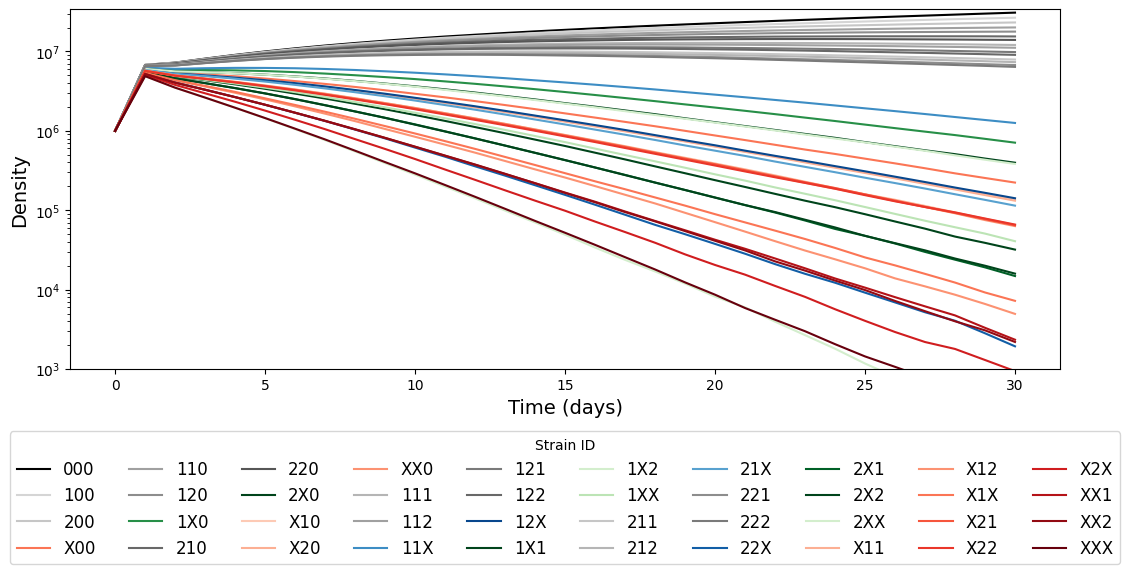

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_accessible_A0_final_density_bar.pdf


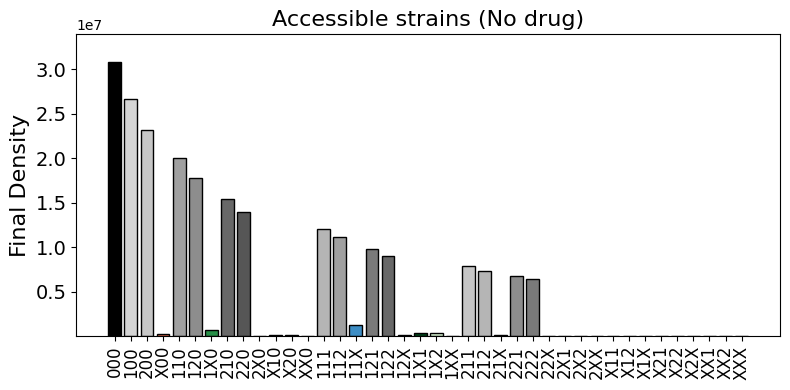

In [27]:

# Define initial populations for each strain
initial_populations = np.array([B0] * len(strains_accessible))

# Run the multi-day simulation
results_accessible_A0 = runSimulation(
    M=M_accessible,
    strains=strains_accessible,
    initial_populations=initial_populations,
    num_days=30,
    antibiotic_concentration=0, #no drug
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    dilution=dilution_factor,
    transition_rate=transition_rate,
    p_sos_min=p_sos_min,
    c_sos=c_sos,
    k_sos=k_sos,
    max_antibiotic_concentration=max_antibiotic_concentration
)



# Combine strain IDs with their final population densities
initial_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains_accessible, initial_populations)]
initial_sorted_strains = sorted(initial_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in initial_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Initial Density: {density}")
print(" ")

# Combine strain IDs with their final population densities
final_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains_accessible, results_accessible_A0[-1]['final_populations'])]
final_sorted_strains = sorted(final_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in final_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Final Density: {density}")


outPath='%s_accessible_A0'%(file_name_figures)
plotPopulationDynamics(results_accessible_A0, days=range(1, num_days + 1), strains=strains_accessible, initial_populations=initial_populations, ncol=10, outPath=outPath)


plotFinalDensityBar(results_accessible_A0, labels_genotypes_accessible, strains_accessible, title='Accessible strains (No drug)', outPath=outPath)

### Evolutionary experiment (accessible genotypes, with drug)

Strain ID: 000, Initial Density: 1000000.0
Strain ID: 100, Initial Density: 1000000.0
Strain ID: 200, Initial Density: 1000000.0
Strain ID: X00, Initial Density: 1000000.0
Strain ID: 110, Initial Density: 1000000.0
 
Strain ID: 2XX, Final Density: 29346411.712029636
Strain ID: XXX, Final Density: 4036476.9120946825
Strain ID: X2X, Final Density: 79269.19900698803
Strain ID: XX0, Final Density: 29341.3290280106
Strain ID: 2X0, Final Density: 17115.817539224954
Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_accessible_Amax_population_dynamics.pdf


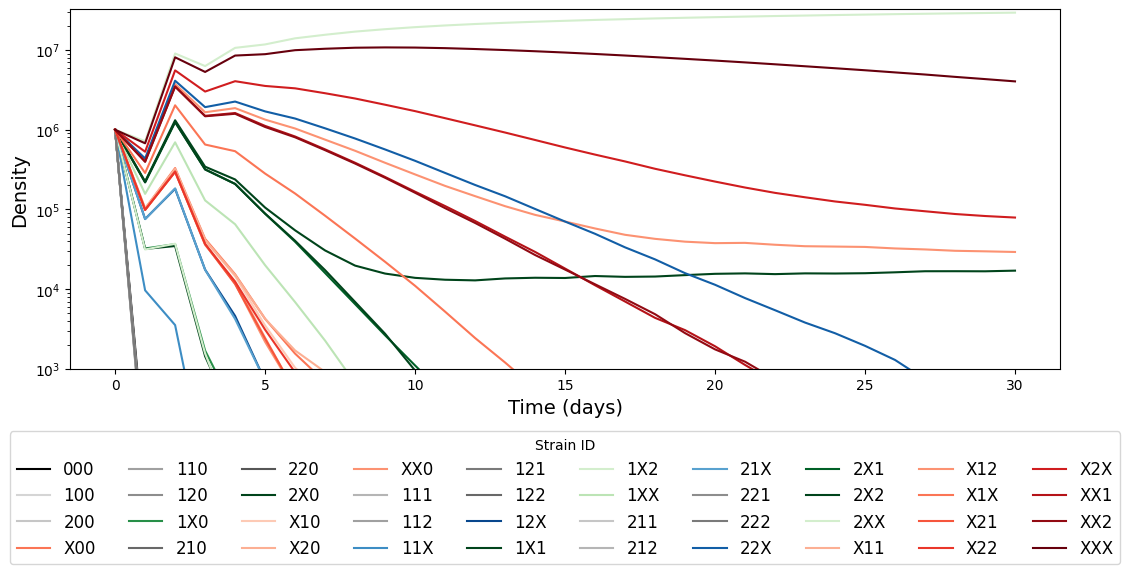

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_accessible_Amax_final_density_bar.pdf


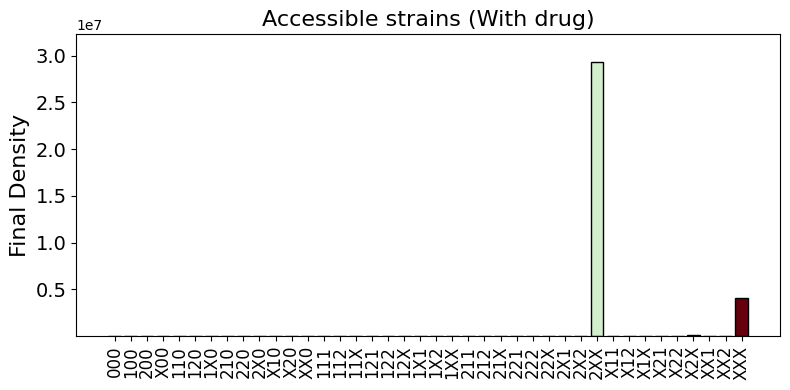

In [28]:

# Define initial populations for each strain
initial_populations = np.array([B0] * len(strains_accessible))

# Run the multi-day simulation
results_accessible_Amax = runSimulation(
    M=M_accessible,
    strains=strains_accessible,
    initial_populations=initial_populations,
    num_days=num_days,
    antibiotic_concentration=max_antibiotic_concentration,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    dilution=dilution_factor,
    transition_rate=transition_rate,
    p_sos_min=p_sos_min,
    c_sos=c_sos,
    k_sos=k_sos,
    max_antibiotic_concentration=max_antibiotic_concentration
)



# Combine strain IDs with their final population densities
initial_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains_accessible, initial_populations)]
initial_sorted_strains = sorted(initial_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in initial_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Initial Density: {density}")
print(" ")

# Combine strain IDs with their final population densities
final_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains_accessible, results_accessible_Amax[-1]['final_populations'])]
final_sorted_strains = sorted(final_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in final_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Final Density: {density}")



outPath='%s_accessible_Amax'%(file_name_figures)
plotPopulationDynamics(results_accessible_Amax, days=range(1, num_days + 1), strains=strains_accessible, initial_populations=initial_populations, ncol=10, outPath=outPath)


plotFinalDensityBar(results_accessible_Amax, labels_genotypes_accessible, strains_accessible, title='Accessible strains (With drug)', outPath=outPath)

### Evolutionary experiment (starting from a clonal population, no drug)

Strain ID: 12X, Initial Density: 1000000
 
Strain ID: 12X, Final Density: 218105650.631558
Strain ID: 120, Final Density: 3519150.479023972
Strain ID: 1X0, Final Density: 335053.7083154809
Strain ID: 21X, Final Density: 91821.98591014395
Strain ID: 2X0, Final Density: 78373.80790460137
Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_clonal_A0_population_dynamics.pdf


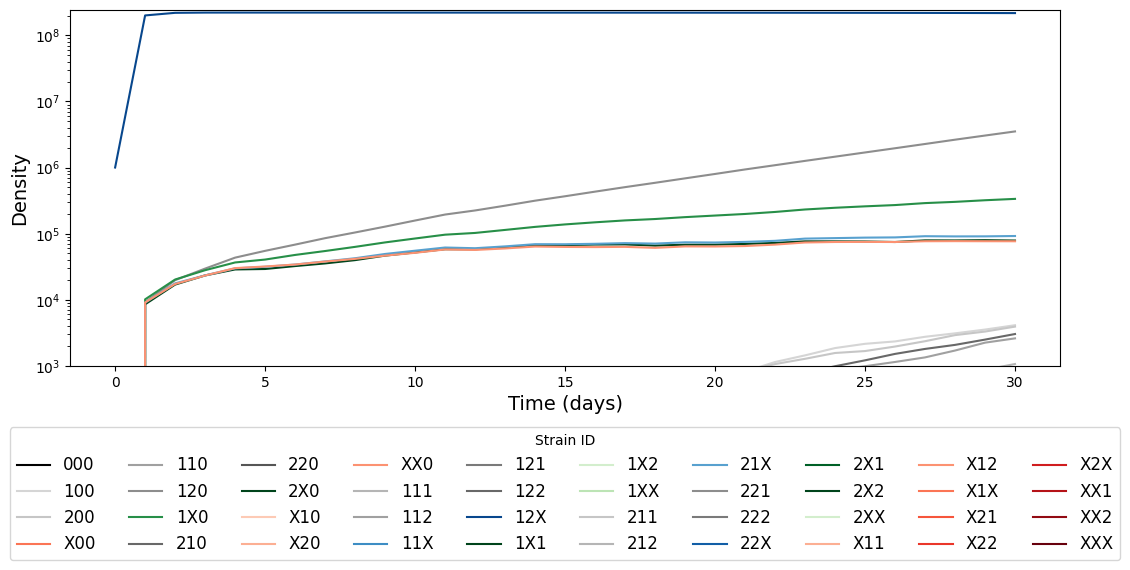

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_clonal_A0_final_density_bar.pdf


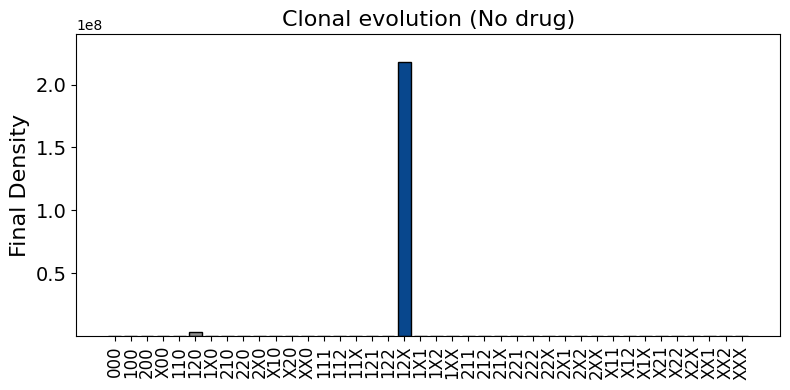

In [29]:


# Define initial populations for each strain
initial_populations = np.array([0] * len(strains_accessible))
genotype_to_find = initial_genotype_label
index_of_genotype = labels_genotypes_accessible.index(genotype_to_find) if genotype_to_find in labels_genotypes_accessible else None
initial_populations[index_of_genotype]=B0

# Run the multi-day simulation
results_clonal_A0 = runSimulation(
    M=M_accessible,
    strains=strains_accessible,
    initial_populations=initial_populations,
    num_days=num_days,
    antibiotic_concentration=0.0, #no drug
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    dilution=dilution_factor,
    transition_rate=transition_rate,
    p_sos_min=p_sos_min,
    c_sos=c_sos,
    k_sos=k_sos,
    max_antibiotic_concentration=max_antibiotic_concentration
)


# Combine strain IDs with their final population densities
initial_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains_accessible, initial_populations)]
initial_sorted_strains = sorted(initial_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in initial_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Initial Density: {density}")
print(" ")

# Combine strain IDs with their final population densities
final_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains_accessible, results_clonal_A0[-1]['final_populations'])]
final_sorted_strains = sorted(final_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in final_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Final Density: {density}")




outPath='%s_clonal_A0'%(file_name_figures)
plotPopulationDynamics(results_clonal_A0, days=range(1, num_days + 1), strains=strains_accessible, initial_populations=initial_populations, ncol=10, outPath=outPath)

plotFinalDensityBar(results_clonal_A0, labels_genotypes_accessible, strains_accessible, title='Clonal evolution (No drug)', outPath=outPath)


### Evolutionary experiment (strting from clonal population, with drug)

Strain ID: 12X, Initial Density: 1000000
 
Strain ID: X2X, Final Density: 21967503.35029517
Strain ID: 2XX, Final Density: 6552409.79934508
Strain ID: 22X, Final Density: 823024.1549282111
Strain ID: XX0, Final Density: 36641.7438373513
Strain ID: XX2, Final Density: 26089.95507270738
Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_clonal_Amax_population_dynamics.pdf


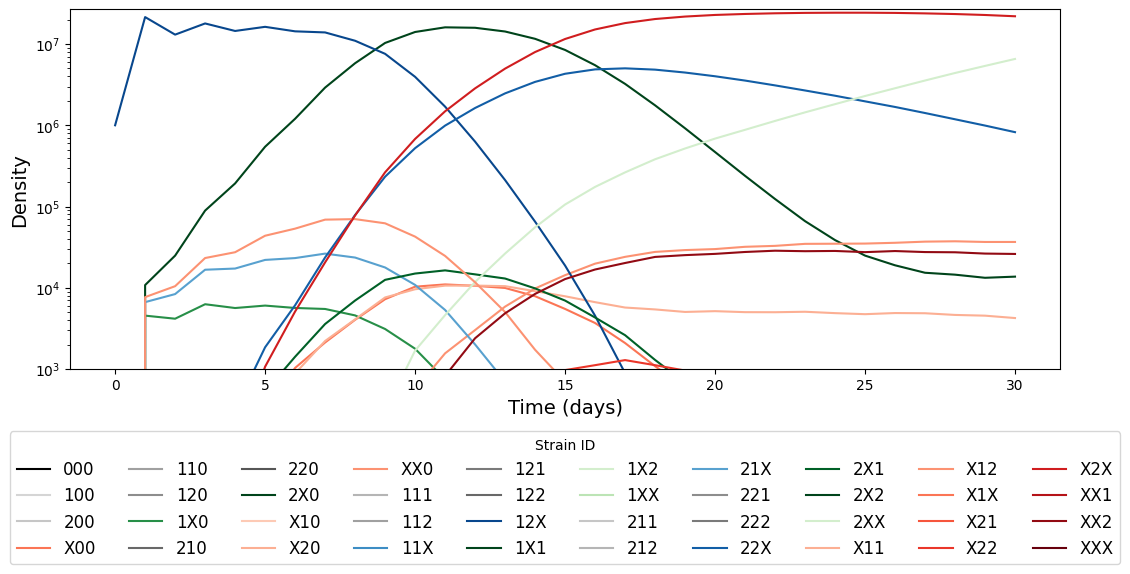

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_clonal_Amax_final_density_bar.pdf


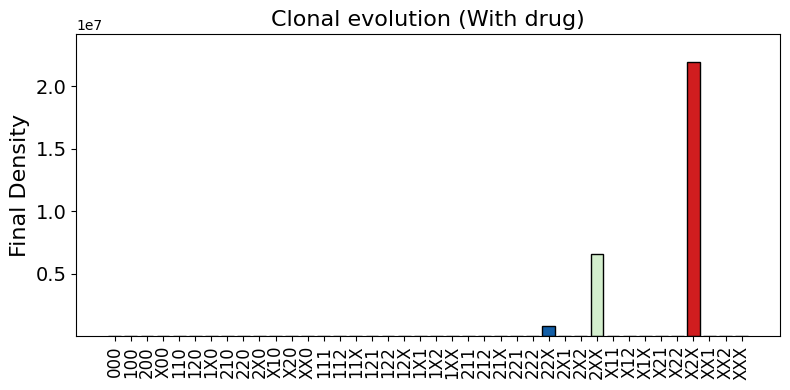

In [30]:


# Define initial populations for each strain
initial_populations = np.array([0] * len(strains_accessible))
genotype_to_find = initial_genotype_label
index_of_genotype = labels_genotypes_accessible.index(genotype_to_find) if genotype_to_find in labels_genotypes_accessible else None
initial_populations[index_of_genotype]=B0

# Run the multi-day simulation
results_clonal_Amax = runSimulation(
    M=M_accessible,
    strains=strains_accessible,
    initial_populations=initial_populations,
    num_days=num_days,
    antibiotic_concentration=max_antibiotic_concentration,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    dilution=dilution_factor,
    transition_rate=transition_rate,
    p_sos_min=p_sos_min,
    c_sos=c_sos,
    k_sos=k_sos,
    max_antibiotic_concentration=max_antibiotic_concentration,
    verbose=False
)

# Combine strain IDs with their final population densities
initial_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains_accessible, initial_populations)]
initial_sorted_strains = sorted(initial_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in initial_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Initial Density: {density}")
print(" ")

# Combine strain IDs with their final population densities
final_strain_populations = [(strain['strainID'], density) for strain, density in zip(strains_accessible, results_clonal_Amax[-1]['final_populations'])]
final_sorted_strains = sorted(final_strain_populations, key=lambda x: x[1], reverse=True)[:5]
for strain_id, density in final_sorted_strains:
    if density>0:
        print(f"Strain ID: {strain_id}, Final Density: {density}")



outPath='%s_clonal_Amax'%(file_name_figures)
plotPopulationDynamics(results_clonal_Amax, days=range(1, num_days + 1), strains=strains_accessible, initial_populations=initial_populations, ncol=10, outPath=outPath)


plotFinalDensityBar(results_clonal_Amax, labels_genotypes_accessible, strains_accessible, title='Clonal evolution (With drug)', outPath=outPath)

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_smr1/X_aacA37_smr1_total_population_total_population_dynamics.pdf


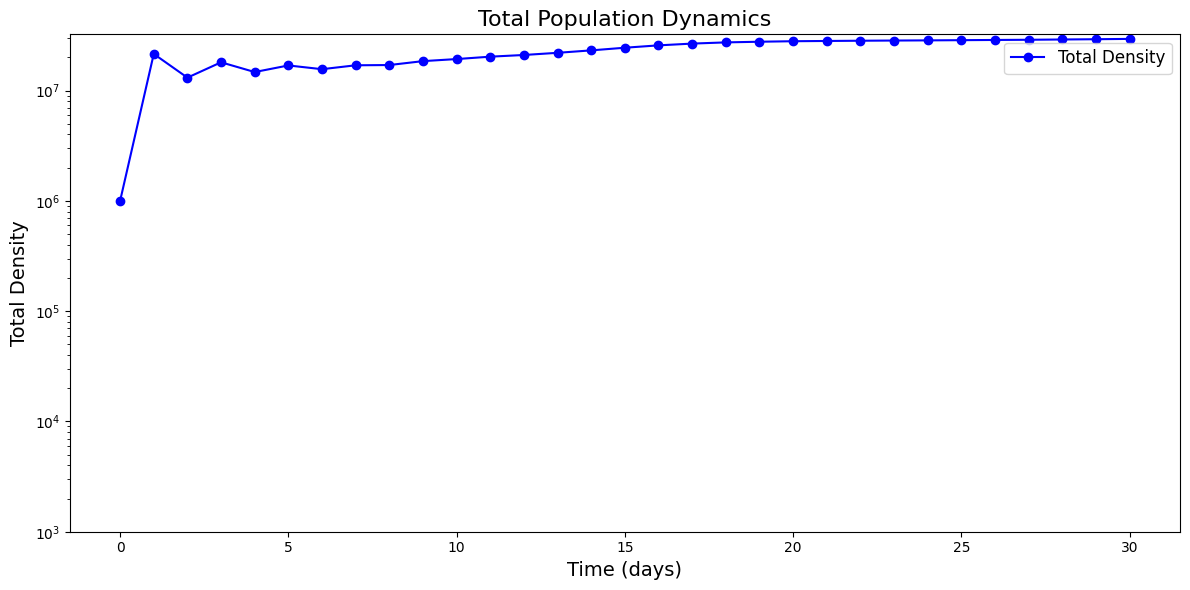

In [31]:


outPath = '%s_total_population' % file_name_figures
plotTotalPopulationDynamics(results_clonal_Amax, range(1, num_days + 1), initial_populations, outPath=outPath)
